In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage as montage
from skimage.morphology import label
from supports import rle_decode, rle_encode, masks_as_image, multi_rle_encode
import gc
import warnings

gc.enable()
warnings.filterwarnings('ignore')

In [2]:
ship_dir = './dataset'
train_image_dir = os.path.join(ship_dir, 'train')
# test_image_dit = os.path.join(ship_dir, 'test')

In [3]:
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations.csv'))
print('%d masks found' % masks.shape[0])

131030 masks found


# test encode/decode

check encode/decode


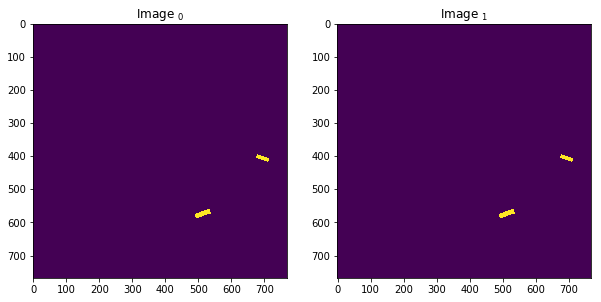

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
# load encoded pixels
rle_0 = masks.query('ImageId=="00aa60389.jpg"')['EncodedPixels']
# decode pixels to images
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0.reshape(768, 768))
ax1.set_title('Image $_0$')
# encode images to str
rle_1 = multi_rle_encode(img_0)
# redecode
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1.reshape(768,768))
ax2.set_title('Image $_1$')
print('check encode/decode')

# EDA

629 images have ship out of 990


,ImageId,ships,has_ship,has_ship_vec,file_size_kb
3397,08203d2af.jpg,1,1.0,[1.0],110.741211
1442,03612fafe.jpg,1,1.0,[1.0],162.255859
1760,0438460cf.jpg,1,1.0,[1.0],138.922852
2846,06cb32197.jpg,1,1.0,[1.0],139.017578
6,00031f145.jpg,1,1.0,[1.0],232.898438


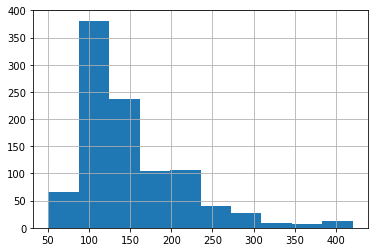

In [5]:
# mark whether have ship
masks['ships'] = masks['EncodedPixels'].map(
    lambda c_row: 1 if isinstance(c_row, str) else 0)
# mark ship count
unique_img_ids = masks.groupby('ImageId').agg({'ships':'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(
    lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# exclude corrupt files
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(
    lambda img_id: os.stat(
    os.path.join(train_image_dir, img_id)).st_size/1024 \
    if os.path.exists(os.path.join(train_image_dir, img_id)) else 0)

unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50]
print('%d images have ship out of %d' % 
      (unique_img_ids['ships'][unique_img_ids['ships']==1].count(), 
       len(unique_img_ids)))

# view result
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

# Split train & validation data

1303 training masks
629 validation masks


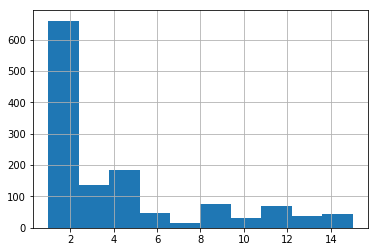

In [6]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(unique_img_ids,
                                       test_size = 0.33,
                                       stratify = unique_img_ids['ships'])

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

# exam frequent ship numbers
train_df['ships'].hist()

In [7]:
# # undersample
# train_df['grouped_ship_count'] = train_df['ships'].map(
#     lambda x: (x+1)//2).clip(0, 7)

# def sample_ships(in_df, base_rep_val=1500):
#     if in_df['ships'].values[0]==0:
#         return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
#     else:
#         return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))

# balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
# balanced_train_df['ships'].hist(bins=np.arange(10))

# Decode al RLEs into Images

In [8]:
def make_image_gen(in_df, batch_size = 4):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [15]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


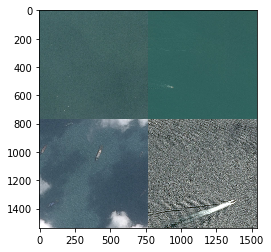

In [16]:
# show a montaged image with 3 channels
plt.imshow(np.stack([montage(train_x[:,:,:,0]),
montage(train_x[:,:,:,1]),
montage(train_x[:,:,:,2])], -1))#.shape

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) \
                                  for i in range(x.shape[3])], -1)

Text(0.5,1,'Outlined Ships')

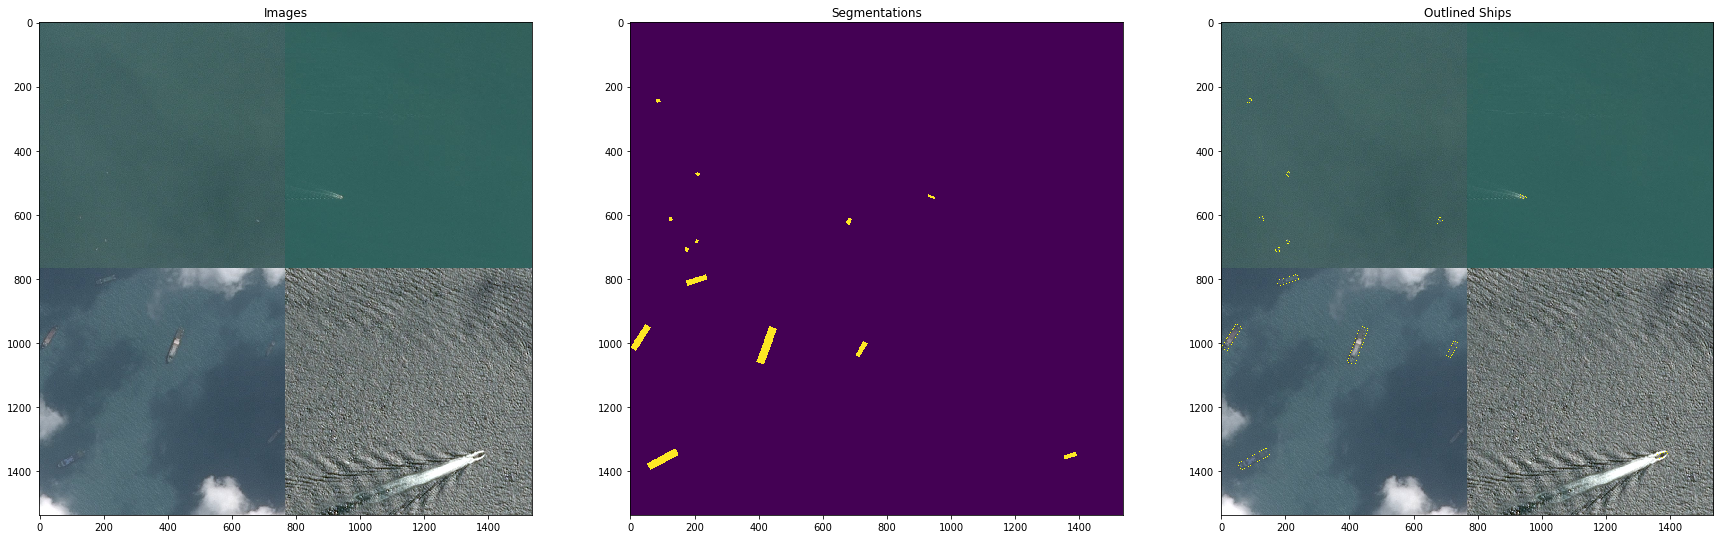

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
# fig.savefig('overview.png')

# Make the validation set

In [18]:
varid_x, vald_y = next(make_image_gen(valid_df), 30)

# Arguements

In [19]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [20]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False,
              samplewise_center = False,
              rotation_range = 15,
              width_shift_range = 0.1,
              #height_shift_range = 0.1,
              shear_range = 0.01,
              zoom_range = [0.9, 1.25],
              horizontal_flip = True,
              vertical_flip = True,
              fill_mode = 'reflect',
              data_format = 'channels_last')
image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)

Using TensorFlow backend.


In [25]:
def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        g_x = image_gen.flow(255 * in_x,
                            batch_size = in_x.shape[0],
                            seed = seed,
                            shuffle = True)
        g_y = label_gen.flow(in_y,
                            batch_size = in_x.shape[0],
                            seed = seed,
                            shuffle = True)
        yield next(g_x)/255.0, next(g_y)

In [26]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


Text(0.5,1,'ships')

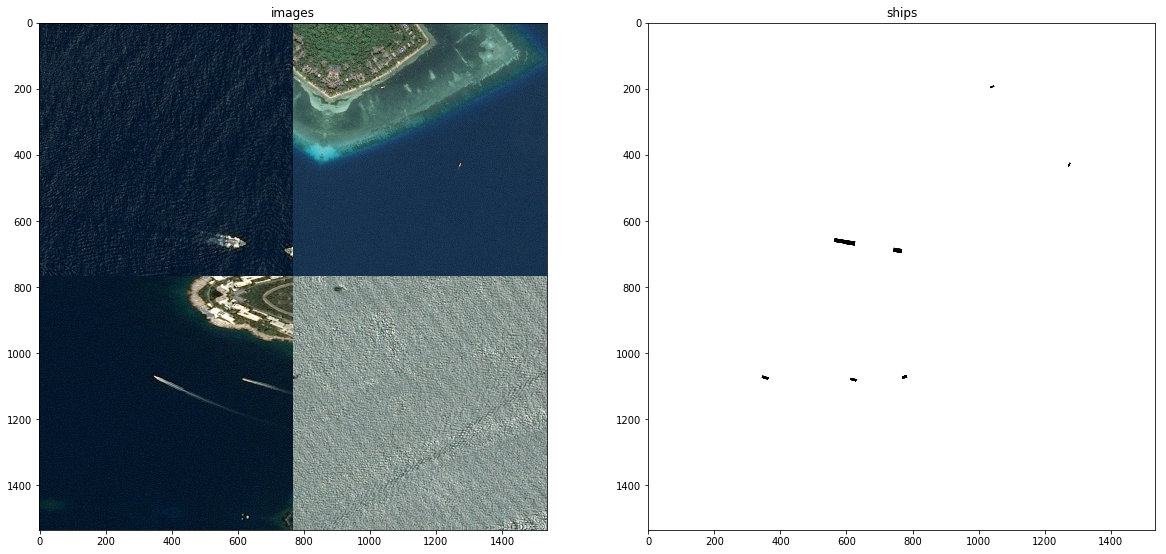

In [38]:
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [39]:
gc.collect()

10

# Model Building

In [43]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)
